In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zulkarnainsaurav/imdb-multimodal-vision-and-nlp-genre-classification")

print("Path to dataset files:", path)

Mounting files to /kaggle/input/imdb-multimodal-vision-and-nlp-genre-classification...
Path to dataset files: /kaggle/input/imdb-multimodal-vision-and-nlp-genre-classification


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

In [5]:
base_dir = '/kaggle/input/imdb-multimodal-vision-and-nlp-genre-classification/IMDB four_genre_posters'
img_size = (224, 224)
batch_size = 32

In [6]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1062 images belonging to 4 classes.
Found 263 images belonging to 4 classes.


In [18]:
base_model_0 = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model_0.trainable = False  # Freeze the convolutional base

model_0 = models.Sequential([
    base_model_0,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')  # 4 output classes
])

model_0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history_0 = model_0.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2924 - loss: 1.3848 - val_accuracy: 0.3004 - val_loss: 1.3813
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2835 - loss: 1.3825 - val_accuracy: 0.3004 - val_loss: 1.3782
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3091 - loss: 1.3752 - val_accuracy: 0.3004 - val_loss: 1.3767
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3147 - loss: 1.3712 - val_accuracy: 0.3004 - val_loss: 1.3765
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3118 - loss: 1.3735 - val_accuracy: 0.3004 - val_loss: 1.3765
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3001 - loss: 1.3762 - val_accuracy: 0.3004 - val_loss: 1.3764
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2960 - loss: 1.3779 - val_accuracy: 0.3004 - val_loss: 1.3764
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2991 - loss: 1.3786 - val_accuracy: 0.3004 - val_loss:

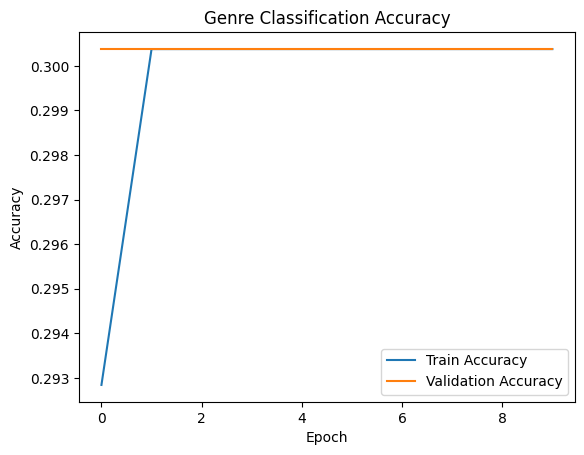

In [21]:
import matplotlib.pyplot as plt

plt.plot(history_0.history['accuracy'], label='Train Accuracy')
plt.plot(history_0.history['val_accuracy'], label='Validation Accuracy')
plt.title('Genre Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

val_gen.reset()
preds = model_0.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 987ms/step
              precision    recall  f1-score   support

      Action       0.00      0.00      0.00        67
      Comedy       0.00      0.00      0.00        64
      Horror       0.30      1.00      0.46        79
     Romance       0.00      0.00      0.00        53

    accuracy                           0.30       263
   macro avg       0.08      0.25      0.12       263
weighted avg       0.09      0.30      0.14       263



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy is stuck at ~30% (barely above random for 4 classes = 25%)

The model predicts everything as 'Horror', ignoring other genres

Precision, recall, and F1 for Action, Comedy, Romance = 0, meaning those classes are never predicted correctly

Only 'Horror' is being classified, with 100% recall (it finds all the horror posters), but it's guessing all inputs are horror

Why this happened?

weights=None: MobileNetV2 is randomly initialized — not pretrained — so it has no meaningful feature extraction ability at the start.

Model is frozen: You're not training the base model (it's frozen), so it never learns useful filters.

Few epochs: 10 epochs may not be enough for a deep model trained from scratch.

Next, we use a pretrained model like MobileNetV2 and ResNet50 to improve results on a small dataset.

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load base model with local weights
base_model = MobileNetV2(
    weights='/kaggle/input/mobilenet_v2_weights.h5/tensorflow2/default/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  

In [12]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')  # 4 genres
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10  # or 5 if you want to test quickly
)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3986 - loss: 1.4041 - val_accuracy: 0.5932 - val_loss: 0.9247
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6575 - loss: 0.8155 - val_accuracy: 0.6122 - val_loss: 0.9177
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7069 - loss: 0.7083 - val_accuracy: 0.6198 - val_loss: 0.9363
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7398 - loss: 0.6894 - val_accuracy: 0.6312 - val_loss: 0.9117
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7942 - loss: 0.5316 - val_accuracy: 0.6312 - val_loss: 0.8832
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8114 - loss: 0.4914 - val_accuracy: 0.6312 - val_loss: 0.8889
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8269 - loss: 0.4739 - val_accuracy: 0.6388 - val_loss: 0.8991
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8428 - loss: 0.4074 - val_accuracy: 0.6236 - val_loss:

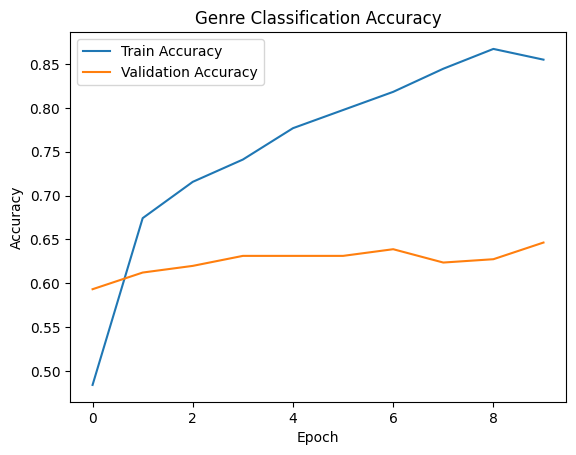

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Genre Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

val_gen.reset()
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step 
              precision    recall  f1-score   support

      Action       0.56      0.72      0.63        67
      Comedy       0.76      0.58      0.65        64
      Horror       0.66      0.81      0.73        79
     Romance       0.66      0.40      0.49        53

    accuracy                           0.65       263
   macro avg       0.66      0.63      0.63       263
weighted avg       0.66      0.65      0.64       263



In [16]:
model.save('mobilenet_genre_classifier.h5')

Overall Accuracy:

Validation Accuracy: ~65%

This is well above random (25%) for a 4-class problem.

Shows that the model learned meaningful patterns from poster images. 

| Genre       | Precision | Recall | F1-Score | Notes                                                                                |
| ----------- | --------- | ------ | -------- | ------------------------------------------------------------------------------------ |
| **Action**  | 0.56      | 0.72   | 0.63     | Good recall — model identifies most Action posters, but makes more false positives.  |
| **Comedy**  | 0.76      | 0.58   | 0.65     | Strong precision — when it predicts Comedy, it’s usually right. Slight under-recall. |
| **Horror**  | 0.66      | 0.81   | 0.73     | Excellent recall and solid F1 — best class performance overall.                      |
| **Romance** | 0.66      | 0.40   | 0.49     | Precision is okay, but **recall is low** — model misses many Romance posters.        |


Training vs. Validation

Train Accuracy: ~85%

Validation Accuracy: ~65%

Indicates slight overfitting, which is normal at this stage.

Validation accuracy is stable but plateaus after epoch 4–5.

📌 Key Takeaways
✅ Model performs well on Horror and Action genres.

⚠️ Needs improvement on Romance (add more samples or use augmentation).

🔧 We could try:

Unfreezing last few layers of MobileNetV2 for fine-tuning.

Data augmentation to reduce overfitting.

Class weighting if the dataset is imbalanced.

In [23]:
# Unfreeze the top layers (say, top 50 layers)
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with lower learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5  # fewer epochs for fine-tuning
)

Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6804 - loss: 0.7921 - val_accuracy: 0.6388 - val_loss: 0.9280
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7450 - loss: 0.6352 - val_accuracy: 0.6426 - val_loss: 0.9087
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7705 - loss: 0.5686 - val_accuracy: 0.6616 - val_loss: 0.8927
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8029 - loss: 0.5214 - val_accuracy: 0.6540 - val_loss: 0.8879
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8402 - loss: 0.4300 - val_accuracy: 0.6578 - val_loss: 0.8892


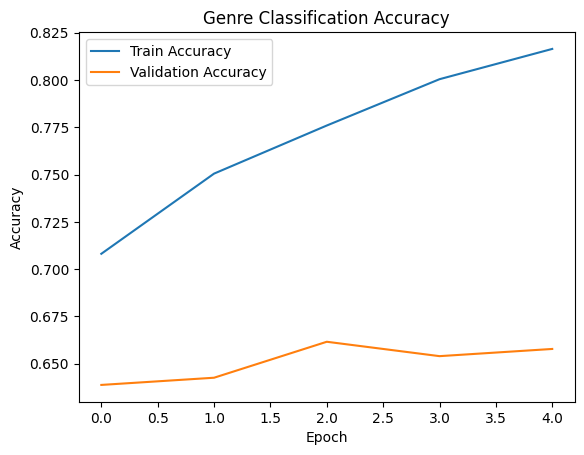

In [25]:
import matplotlib.pyplot as plt

plt.plot(history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy')
plt.title('Genre Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

val_gen.reset()
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 986ms/step
              precision    recall  f1-score   support

      Action       0.63      0.63      0.63        67
      Comedy       0.68      0.77      0.72        64
      Horror       0.70      0.77      0.73        79
     Romance       0.57      0.40      0.47        53

    accuracy                           0.66       263
   macro avg       0.64      0.64      0.64       263
weighted avg       0.65      0.66      0.65       263



Fine-Tuned Model Performance Interpretation
🎯 Overall Accuracy
Validation Accuracy improved to ~66% (vs. ~64–65% before)

Training Accuracy reached 84%, showing stronger learning

Still a small generalization gap, but not alarming

| Genre       | Precision | Recall | F1-Score | Notes                                                                    |
| ----------- | --------- | ------ | -------- | ------------------------------------------------------------------------ |
| **Action**  | 0.63      | 0.63   | 0.63     | Balanced, but not the strongest class.                                   |
| **Comedy**  | 0.68      | 0.77   | 0.72     | Best performance — both precision & recall are high.                     |
| **Horror**  | 0.70      | 0.77   | 0.73     | Strong and consistent — model identifies horror well.                    |
| **Romance** | 0.57      | 0.40   | 0.47     | Still weakest class — recall is low (model misses many Romance posters). |


Accuracy Trends
Train accuracy keeps rising → model is still learning

Validation accuracy plateaus after epoch 3

Indicates optimal point has likely been reached

Further training may not help unless:

You add more data

You augment or balance classes

📌 Final Thoughts

✅ Fine-tuning helped!

📈 Model generalizes better, especially for Comedy and Horror

⚠️ Romance is still underperforming → may need:

More examples

Data augmentation

Class weighting

In [27]:
model.save('mobilenet_genre_finetuned.h5')